# Data Parse

In [2]:
import subprocess
import requests
import pandas as pd
import json

In [3]:
#trial

def fetch_nutrients_dataframe():
    command = ['python', 'https://github.com/calvinkochunisg/HSG-CS-Project/blob/dev/api/spoonacular.py']

    # Run the command and capture the output
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    # Check if the script executed successfully
    if result.returncode == 0:
        # The script executed successfully, process the stdout
        url_output = result.stdout.strip()
    else:
        # There was an error executing the script, process the stderr
        print(f"Error executing script: {result.stderr}")
        return None

    if url_output:
        url = url_output
        print(f"URL: {url}")
    else:
        print("No URL captured from the script output.")
        return None

    # Make a GET request to the URL
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
    else:
        print(f"Failed to fetch data, status code: {response.status_code}")
        return None

    # Initialize a list to hold structured nutrient data
    structured_nutrients = []

    # Iterate over each day in the data
    for day, content in data['week'].items():
        # Extract nutrients data and include the day of the week
        nutrients_data = {
            'Day': day.capitalize(),
            'Calories': content['nutrients']['calories'],
            'Protein': content['nutrients']['protein'],
            'Fat': content['nutrients']['fat'],
            'Carbohydrates': content['nutrients']['carbohydrates']
        }
        # Append the nutrients data to the list
        structured_nutrients.append(nutrients_data)

    # Convert the list of nutrients data into a DataFrame
    df_nutrients = pd.DataFrame(structured_nutrients)
    return df_nutrients

# Call the function and get the nutrients DataFrame
df_nutrients = fetch_nutrients_dataframe()

if df_nutrients is not None:
    print(df_nutrients)

Error executing script: python: can't open file '//https://github.com/calvinkochunisg/HSG-CS-Project/blob/dev/api/spoonacular.py': [Errno 2] No such file or directory



## User dataframe

### Calories

In [14]:
url = "https://api.spoonacular.com/mealplanner/generate?apiKey=4deaceca7a6448ba9d2006710177aad3&timeframe=week&diet=vegetarian"

def parse(url):    
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
    else:
        print(f"Failed to fetch data, status code: {response.status_code}")
        return None
    structured_nutrients = []

    # Iterate over each day in the data
    for day, content in data['week'].items():
        # Extract nutrients data and include the day of the week
        nutrients_data = {
            'Day': day.capitalize(),
            'calories': content['nutrients']['calories'],
            'Protein': content['nutrients']['protein'],
            'Fat': content['nutrients']['fat'],
            'Carbohydrates': content['nutrients']['carbohydrates']
        }
        # Append the nutrients data to the list
        structured_nutrients.append(nutrients_data)

    # Convert the list of nutrients data into a DataFrame
    user_cal = pd.DataFrame(structured_nutrients)
    user_cal = user_cal[["calories"]]
    return user_cal

# Call the function and get the nutrients DataFrame
user_cal = parse(url)

user_cal

,calories
0,1915.75
1,1953.83
2,1975.22
3,1941.76
4,1905.37
5,1941.28
6,1932.71


### Convert

In [15]:
# this function is use to convert the planned workout session into binary variables for prediction

def convert(url, walk_days, run_days, weights_days, wine_days):
    user_cal = parse(url)
    # get function for url
    week = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]
    walk = []
    run = []
    wine = []
    weights = []

    for day in week:
        if day in walk_days:
            walk.append(1)
        else:
            walk.append(0)

    for day in week:
        if day in run_days:
            run.append(1)
        else:
            run.append(0)

    for day in week:
        if day in wine_days:
            wine.append(1)
        else:
            wine.append(0)

    for day in week:
        if day in weights_days:
            weights.append(1)
        else:
            weights.append(0)

    user_rhy = pd.DataFrame({
                        'walk': walk,
                        'run': run,
                        'wine': wine,
                        'weight': weights})
    
    user_data = pd.concat([user_cal,user_rhy], axis=1)
    user_data.reset_index(drop=True, inplace=True)
    user_data.index = ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]
    return user_data

# Example usage
list_date = ["tue", "thu", "sun"]
list_date2 = ["mon", "thu", "sun"]
list_date3 = ["tue", "wed", "sat"]
list_date4 = ["tue", "fri", "sun"]

user_data = convert(url, list_date, list_date2, list_date3, list_date4)
user_data

,calories,walk,run,wine,weight
mon,1948.62,0,1,0,0
tue,1941.28,1,0,1,1
wed,1948.62,0,0,0,1
thu,1970.01,1,1,0,0
fri,1970.01,0,0,1,0
sat,1941.28,0,0,0,1
sun,1905.37,1,1,1,0


# Modelling

### Preparation

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from io import StringIO

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# URL to the raw CSV file on GitHub
url = "https://raw.githubusercontent.com/calvinkochunisg/HSG-CS-Project/dev/Data/diet_data%202.csv"
response = requests.get(url, verify=False)
if response.status_code == 200:
    data = StringIO(response.text)
    data = pd.read_csv(data)
    print(data.head())
else:
    print('Failed to retrieve data:', response.status_code)

        Date  Stone  Pounds  Ounces  weight_oz  calories cals_per_oz  \
0  7/30/2018   12.0     2.0     6.0     2726.0    1950.0        0.72   
1  7/31/2018   12.0     0.0     8.0     2696.0    2600.0        0.96   
2   8/1/2018   12.0     1.0     0.0     2704.0    2500.0        0.92   
3   8/2/2018   12.0     1.0     0.0     2704.0    1850.0        0.68   
4   8/3/2018   11.0    12.0     8.0     2664.0    2900.0        1.09   

   five_donuts  walk  run  wine  prot  weight  change  
0          1.0   1.0  0.0   0.0   0.0     0.0   -30.0  
1          1.0   0.0  0.0   0.0   0.0     0.0     8.0  
2          1.0   1.0  0.0   0.0   0.0     0.0     0.0  
3          1.0   1.0  0.0   1.0   0.0     0.0   -40.0  
4          1.0   1.0  0.0   0.0   0.0     0.0    14.0  


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


### Cleaning

In [31]:
print(data.head())
data.info()

#convert to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data.set_index('Date', inplace=True)
print(data.head())

# converting ounces to kilogram which is a more popular measurement for countries outsides of U.S.
conversion_factor = 0.0283495

data["kg"] = data["weight_oz"]*conversion_factor

# dropping the features with existing information to avoid multicolinearity, 
# "cals_per_oz" and "prot" are dropped as not provided in the API
data_clean = data.drop(["Stone", "Pounds", "Ounces", "five_donuts", 
                        "weight_oz", "cals_per_oz", "prot", "change"], axis=1)
print(data_clean.head())
print(data_clean.info())
print(data_clean.tail(10))

#shifting the "kg" column up because this result is measured before exercising, 
# but it is only useful at the day end to see the result

data_clean['kg'] = data_clean['kg'].shift(-1)

# Remove the last 8 rows of the DataFrame because they are pure NaN
data_clean = data_clean[:-8]
print(data_clean.head())
print(data_clean.tail())

        Date  Stone  Pounds  Ounces  weight_oz  calories cals_per_oz  \
0  7/30/2018   12.0     2.0     6.0     2726.0    1950.0        0.72   
1  7/31/2018   12.0     0.0     8.0     2696.0    2600.0        0.96   
2   8/1/2018   12.0     1.0     0.0     2704.0    2500.0        0.92   
3   8/2/2018   12.0     1.0     0.0     2704.0    1850.0        0.68   
4   8/3/2018   11.0    12.0     8.0     2664.0    2900.0        1.09   

   five_donuts  walk  run  wine  prot  weight  change  
0          1.0   1.0  0.0   0.0   0.0     0.0   -30.0  
1          1.0   0.0  0.0   0.0   0.0     0.0     8.0  
2          1.0   1.0  0.0   0.0   0.0     0.0     0.0  
3          1.0   1.0  0.0   1.0   0.0     0.0   -40.0  
4          1.0   1.0  0.0   0.0   0.0     0.0    14.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         150 non-null    object 


### KNN Imputer

In [32]:
# using two weeks for test data, since the dataset at hand is really small
# too out the last week as anomalie, as a huge dip is observed, maybe the recorder feels motivated than ever as Christmas approaches
data_train = data_clean[data_clean.index < "2018-12-06"]
data_test = data_clean[(data_clean.index >= "2018-12-06") & (data_clean.index <= "2018-12-12")]
print(data_train['kg'].mean())

# KNN imputer to give values to the NaN
imputer = KNNImputer(n_neighbors=5, weights='uniform')
imputed_train_1 = imputer.fit_transform(data_train)
imputed_train = pd.DataFrame(imputed_train_1, index=data_train.index, columns=data_train.columns)
print(imputed_train.shape)

imputed_test_1 = imputer.fit_transform(data_test)
imputed_test = pd.DataFrame(imputed_test_1, index=data_test.index, columns=data_test.columns)
print(imputed_test.shape)

missing_values = imputed_train.isnull().sum().sum()
print("Missing values in the DataFrame:", missing_values)



(129, 6)
(7, 6)
Missing values in the DataFrame: 0


### XGBoost

In [33]:
# Splitting the data into features and target
X_train = imputed_train.drop("kg", axis=1)
y_train = imputed_train["kg"]
X_test = imputed_test.drop("kg", axis=1)
y_test = imputed_test["kg"]

# Initialize and train the XGBoost model
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=100, seed=42)
model_xgb.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = model_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.18091060891153982


OSError: [Errno 30] Read-only file system: 'model_xgb.pkl'

### Save the model

In [38]:
import pickle
import os

path = "/Users/shinanchen/Desktop/"  # Make sure there's a trailing slash
filename = 'model.sav'
full_path = os.path.join(path, filename)  # Use os.path.join to avoid such errors

# Save the model
with open(full_path, 'wb') as file:
    pickle.dump(model_xgb, file)

print(f"Model saved successfully at {full_path}")


Model saved successfully at /Users/shinanchen/Desktop/model.sav


# User Prediction

In [16]:
import requests
import pickle
from io import BytesIO

# Correct URL to the raw file on GitHub (make sure to replace it with your actual raw URL)
url = "https://github.com/calvinkochunisg/HSG-CS-Project/raw/dev/Data/model.sav"

# Download the file
response = requests.get(url)
if response.status_code == 200:
    # Load the model from the downloaded bytes
    model_data = BytesIO(response.content)
    loaded_model = pickle.load(model_data)

    # Assuming 'user_data' is defined and appropriate for model prediction
    prediction = loaded_model.predict(user_data)
    print("Prediction:", prediction)
else:
    print("Failed to download the file. Status code:", response.status_code)


Prediction: [76.44584 75.80563 76.16637 76.57181 75.63567 76.16637 76.15508]


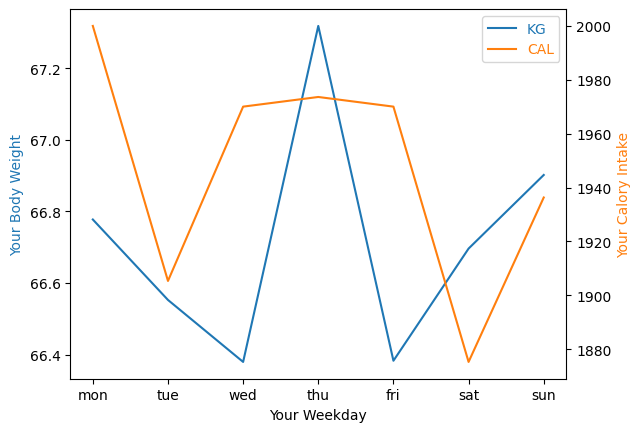

In [49]:
#cal
#Sample
url_user = "https://api.spoonacular.com/mealplanner/generate?apiKey=4deaceca7a6448ba9d2006710177aad3&timeframe=week&diet=vegetarian"
user_input1 = ["tue", "thu", "sun"] #walk
user_input2 = ["mon", "thu", "sun"] #run
user_input3  = ["tue", "wed", "sat"] #wine
user_input4  = ["tue", "fri", "sun"] #weight
user_weight = 65

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def pred(url_user, user_input1, user_input2, user_input3, user_input4, weight):
    url = "https://github.com/calvinkochunisg/HSG-CS-Project/raw/dev/Data/model.sav"
    user_data = convert(url_user, list_date, list_date2, list_date3, list_date4)
    weight_diff = 76.253 - weight
    
    response = requests.get(url)
    if response.status_code == 200:
        model_data = BytesIO(response.content)
        loaded_model = pickle.load(model_data)
        #adjusted weight
        prediction = loaded_model.predict(user_data) - weight_diff
        pred = pd.DataFrame(prediction, columns=['pred'])
        pred.reset_index(drop=True, inplace=True)
        pred.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

        host = host_subplot(111)
        par = host.twinx()

        host.set_xlabel("Your Weekday")
        host.set_ylabel("Your Body Weight")
        par.set_ylabel("Your Calory Intake")

        p1, = host.plot(user_data.index, pred, label="KG")
        p2, = par.plot(user_data.index, user_data["calories"], label="CAL")

        host.legend(labelcolor="linecolor")

        host.yaxis.get_label().set_color(p1.get_color())
        par.yaxis.get_label().set_color(p2.get_color())

        plt.show()

    else:
        print("Failed to download the file. Status code:", response.status_code)

    return host 

prediction = pred(url_user, user_input1, user_input2, user_input3, user_input4,67)
